# Metodos de ensamble

Los métodos de ensamble en machine learning son técnicas que combinan múltiples modelos base para mejorar el rendimiento predictivo y la generalización del modelo. Aquí tienes un resumen de los métodos de ensamble más comunes:

**1. Bagging (Bootstrap Aggregating):**

Utiliza múltiples instancias del mismo algoritmo de aprendizaje, entrenadas en diferentes subconjuntos de datos de entrenamiento generados mediante el muestreo con reemplazo.  
Ejemplo popular: Random Forest.  

**2. Boosting:**

Entrena una secuencia de modelos débiles, donde cada modelo intenta corregir los errores del modelo anterior.
Ejemplos populares: AdaBoost, Gradient Boosting Machines (GBM), XGBoost, LightGBM, CatBoost.  

**3. Stacking (Stacked Generalization):** 

Combina las predicciones de varios modelos base utilizando otro modelo, conocido como meta-modelo, que aprende a predecir el resultado final.  
Puede ser más complejo de implementar que otros métodos de ensamble.  

**4. Voting:**

Combina las predicciones de múltiples modelos base y produce una predicción final mediante un esquema de votación simple o ponderado.  
Puede ser Hard Voting (voto mayoritario) o Soft Voting (promedio de probabilidades).  

**5. Random Subspace Method:**  

Similar a Bagging, pero en lugar de muestrear instancias, muestrea características (columnas) del conjunto de datos de entrenamiento para entrenar cada modelo.  

**6. Random Patches Method:**  

Combina Bagging y Random Subspace Method al muestrear tanto instancias como características para entrenar cada modelo.  

Estos métodos de ensamble pueden mejorar significativamente el rendimiento predictivo en una amplia variedad de conjuntos de datos y problemas de machine learning, especialmente cuando se utilizan en conjunto con modelos base fuertes y diversos. La elección del método de ensamble adecuado depende de la naturaleza del problema, el conjunto de datos y las características de los modelos base disponibles


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from mls import *
from prepro import pprint,prepro

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
from imblearn.pipeline import Pipeline as pipeline_sampler
from imblearn.over_sampling import ADASYN

In [8]:
df=(prepro(path='data.xlsx',n=10,info=False).pipe(seleccion))
pprint(df.head(3),'',2)

El dataset contiene 514 filas y 21 columnas


,SEXO,PSNR,SUBTIPO,MRSS,RAYNAUD,ULCERAS,DISCROMIAS,ROCES_TENDINOSOS,CONTRACTURAS_FLEX,ARTRITIS,EPID,HAP,CRISIS_RENAL,AESOFAGICA,AGASTRICA,AINTESTINAL,PERDIDA_PESO,ANEMIA,EDAD_DEBUT,EXITUS5,CFC
0,0,Endurecimiento piel,0,6,0,0,0,0,1,0,0,0,0,1,0,0,1,1,66,1,CF2
1,0,Endurecimiento piel,0,24,1,1,0,1,0,0,0,0,0,0,0,0,0,1,66,1,CF2
2,0,Puffy hand,1,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,74,1,CF2


## Bagging: Random forest

- Los diferentes estimadores son arboles independientes construidos a partir de muestras aleatorias del train con reemplazo (bootstraping)
- Para cada bootstrap, se entrena un arbol utilizando un subconjunto aleatorio de variables (por defecto la sqrt del nº total de variables)
- Se realiza una votacion mayoritaria para determinar la clase final de cada observacion (fila)
- Se seleccionan las mejores divisiones de cada nodo vistas en los diferentes arboles

### Random forest

In [9]:
y=df.exitus5
x=df.drop(columns='exitus5')
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [35]:
prepro = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), x._get_numeric_data().columns),
        ("encoder", OneHotEncoder(handle_unknown="ignore"), ['CFc','PSNR'])],
    remainder='passthrough',verbose_feature_names_out=False)

rfmod = Pipeline(steps=[("prepro", prepro), 
           ("rf",RandomForestClassifier())])

In [117]:
params = {
    'rf__n_estimators' : [100, 150],
    'rf__max_features' : [None, 0.33,.5],
    'rf__max_depth' : [5,7,9,11],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__ccp_alpha': [.02]
}

In [118]:
grid = GridSearchCV(estimator = rfmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

grid.fit(xtrain,ytrain)

GridSearchCV(estimator=Pipeline(steps=[('prepro',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['mRSS', 'edad_debut'], dtype='object')),
                                                                        ('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CFc',
                                                                          'PSNR'])],
                                                          verbose_feature_names_out=False)),
                                       ('sampler',
                                        ADASYN(sampling_strategy=0.9)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__ccp_alpha': [0.02],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [5, 7, 9, 11],
                         'rf__max_features': [None, 0.33, 0.5],
                         'rf__n_estimators': [100, 150]},
             scoring='recall')

In [119]:
mejor=best_grid(grid,xtrain,ytrain)

Mejor score: 0.7314285714285715
Mejores parametros: {'rf__ccp_alpha': 0.02, 'rf__criterion': 'gini', 'rf__max_depth': 9, 'rf__max_features': None, 'rf__n_estimators': 150}
Ajustando el mejor modelo...


In [120]:
coefi(mejor,'rf').pipe(pprint,'Random forest',2)

,COEFICIENTES
Variable,
discromias,"0,46"
edad_debut,"0,18"
mRSS,"0,08"
sexo,"0,08"
CFc_CF1,"0,07"
HAP,"0,05"
CFc_CF2,"0,02"
Aesofagica,"0,02"
PSNR_Puffy hand,"0,01"


============= Report classification ==============

Sensibilidad del train: 0.83
Sensibilidad del test: 0.56

              precision    recall  f1-score   support

          No       0.90      0.84      0.87        85
          Si       0.42      0.56      0.48        18

    accuracy                           0.79       103
   macro avg       0.66      0.70      0.67       103
weighted avg       0.81      0.79      0.80       103


========= Confusion matrix train vs test =========



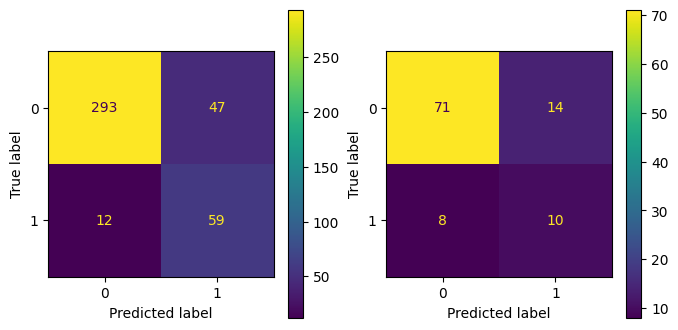

In [121]:
metricas(mejor,xtrain,ytrain,xtest,ytest)

### Random forest con pesos ponderados

Mejor score: 0.7038095238095238
Mejores parametros: {'rf__ccp_alpha': 0.02, 'rf__criterion': 'gini', 'rf__max_depth': 25, 'rf__max_features': None, 'rf__n_estimators': 50}
Ajustando el mejor modelo...


,COEFICIENTES
Variable,
mRSS,"0,58"
edad_debut,"0,16"
CFc_CF1,"0,08"
discromias,"0,06"
CFc_CF2,"0,03"
crisis_renal,"0,02"
Aesofagica,"0,02"
anemia,"0,02"
sexo,"0,01"


============= Report classification ==============

Sensibilidad del train: 0.85
Sensibilidad del test: 0.78

              precision    recall  f1-score   support

          No       0.95      0.81      0.87        85
          Si       0.47      0.78      0.58        18

    accuracy                           0.81       103
   macro avg       0.71      0.79      0.73       103
weighted avg       0.86      0.81      0.82       103


========= Confusion matrix train vs test =========



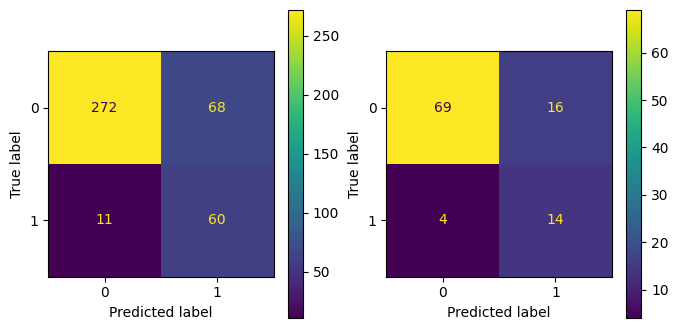

In [25]:
rfmod = Pipeline(steps=[("prepro", prepro), 
           ("rf",RandomForestClassifier(class_weight='balanced_subsample'))])
params = {
    'rf__n_estimators' : [50, 100, 150],
    'rf__max_features' : [None, 0.33,.5],
    'rf__max_depth' : [20,25,30],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__ccp_alpha': [.01,.015,.02]
}

grid = GridSearchCV(estimator = rfmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

grid.fit(xtrain,ytrain)
mejor=best_grid(grid,xtrain,ytrain)
coefi(mejor,'rf').pipe(pprint,'Random forest + pesos ponderados',2)
metricas(mejor,xtrain,ytrain,xtest,ytest)

### Random forest con oversampling

Mejor score: 0.7171428571428571
Mejores parametros: {'rf__ccp_alpha': 0.02, 'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': None, 'rf__n_estimators': 100, 'sampler__n_neighbors': 10}
Ajustando el mejor modelo...


,COEFICIENTES
Variable,
discromias,"0,48"
edad_debut,"0,19"
mRSS,"0,13"
CFc_CF1,"0,05"
sexo,"0,05"
Aesofagica,"0,02"
anemia,"0,02"
CFc_CF2,"0,01"
PSNR_Endurecimiento piel,"0,01"


============= Report classification ==============

Sensibilidad del train: 0.86
Sensibilidad del test: 0.67

              precision    recall  f1-score   support

          No       0.92      0.82      0.87        85
          Si       0.44      0.67      0.53        18

    accuracy                           0.80       103
   macro avg       0.68      0.75      0.70       103
weighted avg       0.84      0.80      0.81       103


========= Confusion matrix train vs test =========



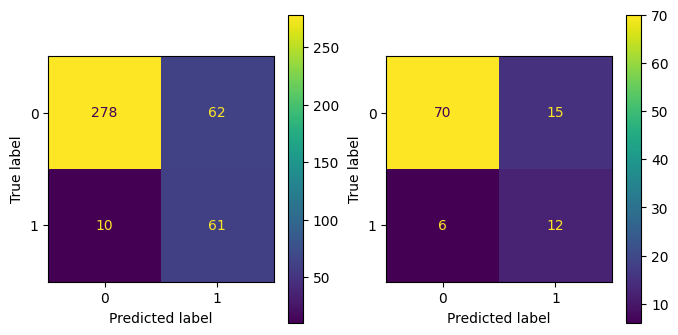

In [58]:
rfmod = pipeline_sampler(steps=[("prepro", prepro),
                               ('sampler',ADASYN(sampling_strategy=.9)),
           ("rf",RandomForestClassifier())])
params = {
    'sampler__n_neighbors':[5,7,10],
    'rf__n_estimators' : [100, 150],
    'rf__max_features' : [None, 0.33,.5],
    'rf__max_depth' : [5,7,9,11],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__ccp_alpha': [.015,.02]}

grid = GridSearchCV(estimator = rfmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

grid.fit(xtrain,ytrain)
mejor=best_grid(grid,xtrain,ytrain)
coefi(mejor,'rf').pipe(pprint,'Random forest + oversampling',2)
metricas(mejor,xtrain,ytrain,xtest,ytest)

## Boosting: Gradient Boosting

Mientras que Random forest se basa en la diversidad de árboles construidos de forma independiente, XGBoost entrena múltiples árboles secuencialmente, donde cada árbol se enfoca en corregir los errores del modelo anterior optimizando la fx de pérdida con descenso de gradiente.

Diferencias en los criterios:
- RandomForestClassifier: Utiliza el método de bagging, donde los árboles se construyen de forma independiente a partir de muestras de datos aleatorias con reemplazo. El criterio principal para construir cada árbol se basa en la reducción de la impureza (como Gini impurity o Entropía) en cada division.     
- 
XGBoost: Utiliza el método de boosting, donde los árboles se construyen secuencialmente para corregir los errores del modelo anter, por lo que el criterio de división se diseña específicamente para minimizar los residuosior. El criterio principal se basa en la minimización de la función de pérdida (como deviance o función de pérdida exponencial) en cada iteración para ajustarse a los residuos del modelo anteriotos casos.


In [34]:
from xgboost import XGBClassifier

In [36]:
425/89

4.775280898876405

In [135]:
gbmod = Pipeline(steps=[("prepro", prepro), 
           ("gb",XGBClassifier(scale_pos_weight=4.75,subsample=.5))])


In [136]:
params = {
    'gb__n_estimators' : [50, 100, 150],
    'gb__reg_alpha': [50],
    'gb__max_depth' : [5,7,9,11],
    'gb__learning_rate': [.01,.015,.02]
}

In [141]:
grid = GridSearchCV(estimator = gbmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

grid.fit(xtrain,ytrain)

GridSearchCV(estimator=Pipeline(steps=[('prepro',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['mRSS', 'edad_debut'], dtype='object')),
                                                                        ('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CFc',
                                                                          'PSNR'])],
                                                          verbose_feature_names_out=False)),
                                       ('gb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsampl...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'gb__learning_rate': [0.01, 0.015, 0.02],
                         'gb__max_depth': [5, 7, 9, 11],
                         'gb__n_estimators': [50, 100, 150],
                         'gb__reg_alpha': [50]},
             scoring='recall')

In [142]:
mejor=best_grid(grid,xtrain,ytrain)

Mejor score: 0.24285714285714288
Mejores parametros: {'gb__learning_rate': 0.015, 'gb__max_depth': 5, 'gb__n_estimators': 150, 'gb__reg_alpha': 50}
Ajustando el mejor modelo...


In [143]:
coefi(mejor,'gb').pipe(pprint,'Mejor modelo GridSearch',2)

,COEFICIENTES
Variable,
edad_debut,"0,18"
mRSS,"0,16"
PSNR_Disfagia,"0,13"
Agastrica,"0,13"
roces_tendinosos,"0,09"
crisis_renal,"0,09"
PSNR_Articular,"0,05"
HAP,"0,05"
PSNR_Puffy hand,"0,04"


============= Report classification ==============

Sensibilidad del train: 0.70
Sensibilidad del test: 0.72

              precision    recall  f1-score   support

          No       0.94      0.85      0.89        85
          Si       0.50      0.72      0.59        18

    accuracy                           0.83       103
   macro avg       0.72      0.78      0.74       103
weighted avg       0.86      0.83      0.84       103


========= Confusion matrix train vs test =========



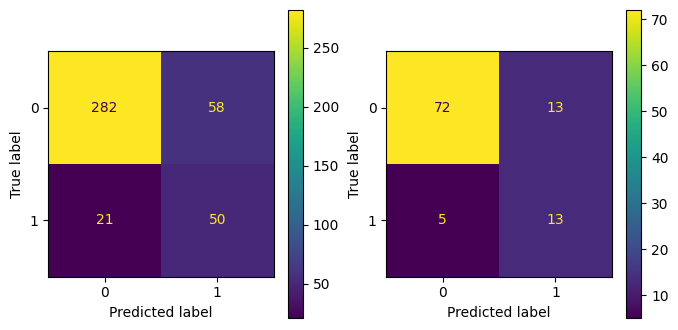

In [144]:
metricas(mejor,xtrain,ytrain,xtest,ytest)

Mejor score: 0.0
Mejores parametros: {'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__n_estimators': 20, 'gb__reg_alpha': 10}
Ajustando el mejor modelo...


,COEFICIENTES
Variable,
mRSS,"0,38"
discromias,"0,15"
HAP,"0,10"
edad_debut,"0,08"
PSNR_Articular,"0,05"
artritis,"0,05"
Aesofagica,"0,05"
Agastrica,"0,05"
Aintestinal,"0,04"


============= Report classification ==============

Sensibilidad del train: 0.00
Sensibilidad del test: 0.00

              precision    recall  f1-score   support

          No       0.83      1.00      0.90        85
          Si       0.00      0.00      0.00        18

    accuracy                           0.83       103
   macro avg       0.41      0.50      0.45       103
weighted avg       0.68      0.83      0.75       103


========= Confusion matrix train vs test =========



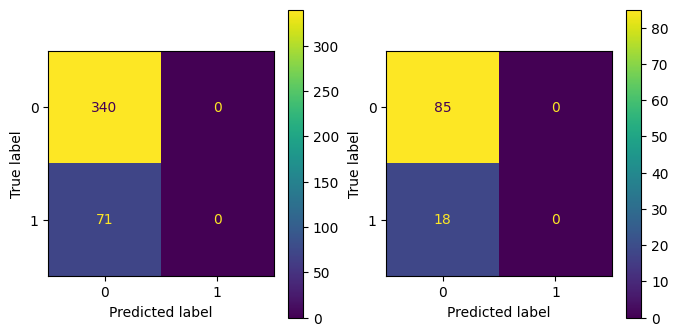

In [145]:
gbmod = Pipeline(steps=[("prepro", prepro), 
           ("gb",XGBClassifier(subsample=.5))])

params = {
    'gb__n_estimators' : [20,30],
    'gb__reg_alpha': [10],
    'gb__max_depth' : [5,7,9,11],
    'gb__learning_rate': [0.03]
}

grid = GridSearchCV(estimator = gbmod, 
                   param_grid = params, 
                   scoring = 'recall',
                   verbose = 0)

grid.fit(xtrain,ytrain)

mejor=best_grid(grid,xtrain,ytrain)

coefi(mejor,'gb').pipe(pprint,'Mejor modelo GridSearch',2)

metricas(mejor,xtrain,ytrain,xtest,ytest)